### <div style="text-align: justify;">PROJETO: PREVENDO DEMANDA DE ESTOQUE COM BASE EM VENDAS - EMPRESA BIMBO DO MÉXICO</div>

### DESCRIÇÃO DOS DADOS


Descrição dos dados dos datasets utilizados neste experimento.

<p>
<div style="text-align: justify;">
Os dados de treino foram coletados do dataset train.csv do Kaggle. Além de coletar amostras, foram realizadas modificações nos nomes das variáveis para uma melhor compreensão delas.
</div>
</p>

Dados de Treino:

- semana: número da semana (de quinta a quarta-feira);
- deposito_id: id do depósito de vendas;
- canal_id: id do canal de vendas;
- rota_id: id da rota (várias rotas = depósito de vendas);
- cliente_id: id do cliente;
- nome_cliente: nome do cliente;
- produto_id: id do produto;
- nome_produto: nome do produto;
- venda_unidade: unidade de vendas desta semana ao fornecedor (inteiro);
- venda_peso: vendas esta semana (unidade: pesos);
- retorno_unidade: unidade de retorno na próxima semana (inteiro);
- devolucao_peso: devoluções na próxima semana (unidade: pesos);
- demanda_ajustada: demanda ajustada (inteiro). (este é o alvo a ser previsto)

### PRÉ-PROCESSAMENTO 

#### CARREGAR BIBLIOTECAS

In [1]:
# DESATIVAR MENSAGENS DE WARNINGS (warn = -1) E ATIVAR (warn = 0)
options(warn = -1)

In [2]:
# DESATIVA NOTAÇÃO CIENTÍFICA
options(scipen = 999)

In [3]:
# PARA TAMANHO DOS GRÁFICOS
options(jupyter.plot_scale = 1)

In [4]:
# CARREGANDO BIBLIOTECAS 
suppressPackageStartupMessages({
library(dplyr)
library(data.table)
library(tibble)
library(readr)
library(tidyr)
library(stringr)
library(ggplot2)
library(ggpubr)
library(cowplot)
library(gridExtra)
library(corrplot)
library(caret)
library(caTools)
library(Rcmdr)
library(xgboost)
})

#### CARREGAR DATASETS

In [5]:
# CARREGAR DATASET DA AMOSTRA DE 245000 OBSERVAÇÕES 
df_bimbo <- fread("df_bimbo.csv", encoding = "UTF-8")

In [6]:
str(df_bimbo)

Classes 'data.table' and 'data.frame':	245000 obs. of  11 variables:
 $ semana          : int  3 3 3 3 3 3 3 3 3 3 ...
 $ deposito_id     : int  1311 1618 1347 3221 1126 1595 1232 1631 2014 1222 ...
 $ canal_venda     : int  1 1 1 1 1 4 1 1 1 1 ...
 $ rota_id         : int  1251 1601 2053 1618 1024 6602 1004 1256 1213 1002 ...
 $ cliente_id      : int  150962 4100032 134877 4588484 1279340 2388568 78925 4295781 886635 61159 ...
 $ produto_id      : int  1146 31719 43147 40217 1150 44371 1160 1309 1240 3144 ...
 $ venda_unidade   : int  1 2 3 1 2 4 8 1 3 1 ...
 $ venda_peso      : num  21.39 15.18 13.62 8.98 27.92 ...
 $ retorno_unidade : int  0 1 0 0 0 0 0 0 0 0 ...
 $ devolucao_peso  : num  0 7.59 0 0 0 0 0 0 0 0 ...
 $ demanda_ajustada: int  1 1 3 1 2 4 8 1 3 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
# CARREGANDO DATASET DE PRODUTOS
df_produto <- fread("df_produto.csv", encoding = "UTF-8"); glimpse(df_produto)

Rows: 2,592
Columns: 2
$ produto_id   <int> 0, 9, 41, 53, 72, 73, 98, 99, 100, 106, 107, 108, 109, 11~
$ nome_produto <chr> "NO IDENTIFICADO 0", "CAPUCCINO MOKA 750G NES 9", "BIMBOL~


In [8]:
# CARREGANDO DATASET DE CLIENTES
df_cliente <- fread("df_cliente.csv", encoding = "UTF-8"); glimpse(df_cliente)

Rows: 935,362
Columns: 2
$ cliente_id   <int> 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ~
$ nome_cliente <chr> "SIN NOMBRE", "OXXO XINANTECATL", "SIN NOMBRE", "EL MOREN~


In [9]:
# CARREGANDO DATASET DE ESTADOS
df_estado <- fread("df_estado.csv", encoding = "UTF-8"); glimpse(df_estado)

Rows: 790
Columns: 3
$ deposito_id <int> 1110, 1111, 1112, 1113, 1114, 1116, 1117, 1118, 1119, 1120~
$ cidade      <chr> "2008 AG. LAGO FILT", "2002 AG. AZCAPOTZALCO", "2004 AG. C~
$ estado      <chr> "MEXICO  D.F.", "MEXICO  D.F.", "ESTADO DE MEXICO", "MEXIC~


#### **AGRUPAMENTO POR PRODUTO**

In [10]:
# PRODUTOS COM MAIOR VENDA EM PESOS E UNIDADES
agrupa_produto <- df_bimbo %>%
    group_by(produto_id) %>%
    summarise(venda_unidade_total = sum(venda_unidade),
              retorno_unidade_total = sum(retorno_unidade),
              demanda_ajustada_total = sum(demanda_ajustada),
              venda_peso_total = sum(venda_peso),
              devolucao_peso_total = sum(devolucao_peso)) %>%
    inner_join(df_produto, by = "produto_id") %>%
    select(produto_id, nome_produto, everything())

glimpse(agrupa_produto)
agrupa_produto <- agrupa_produto[order(agrupa_produto$venda_peso_total, decreasing = T),]

Rows: 1,101
Columns: 7
$ produto_id             <int> 72, 73, 106, 123, 131, 132, 135, 141, 145, 160,~
$ nome_produto           <chr> "DIV TIRA MINI DORADITA 4P 45G TR 72", "PAN MUL~
$ venda_unidade_total    <int> 2602, 2161, 23, 351, 69, 115, 77, 674, 317, 18,~
$ retorno_unidade_total  <int> 42, 52, 0, 0, 0, 0, 0, 6, 1, 0, 0, 2, 0, 0, 0, ~
$ demanda_ajustada_total <int> 2578, 2110, 23, 351, 69, 115, 77, 670, 316, 18,~
$ venda_peso_total       <dbl> 9627.40, 46439.57, 439.07, 7403.34, 1324.80, 16~
$ devolucao_peso_total   <dbl> 155.40, 1110.59, 0.00, 0.00, 0.00, 0.00, 0.00, ~


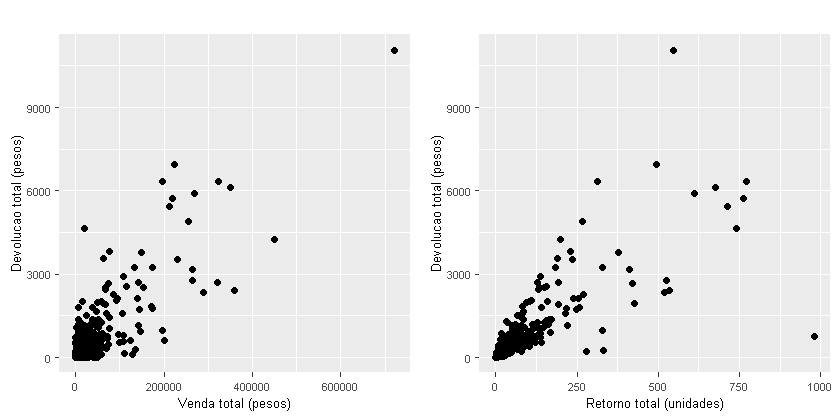

In [11]:
# GRÁFICOS DE DISPERSÃO 
# VENDA TOTAL (PESOS) E RETORNO TOTAL (PESOS) 
g0 <- ggplot(agrupa_produto, aes(x = venda_peso_total, y = devolucao_peso_total)) +
    geom_point() + 
    labs(x = "Venda total (pesos)", y = "Devolucao total (pesos)", title = "") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) 

# RETORNO TOTAL (UNIDADES) E RETORNO TOTAL (PESOS) 
g1 <- ggplot(agrupa_produto, aes(x = retorno_unidade_total, y = devolucao_peso_total)) +
    geom_point() + 
    labs(x = "Retorno total (unidades)", y = "Devolucao total (pesos)", title = "") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8))

options(repr.plot.width = 7, repr.plot.height = 3.5)
plot_grid(g0, g1, ncol = 2, align = "hv")

<p>
<div style="text-align: justify;">
Existe uma correlação forte positiva de vendas totais em pesos e retorno total em unidades com retorno total em pesos. Porém há exceções à essa relação.
</div>
</p>

In [12]:
# 50 PRODUTOS COM MAIS VENDA EM PESOS 
produto_venda_peso <- agrupa_produto[order(agrupa_produto$venda_peso_total, decreasing = T),]

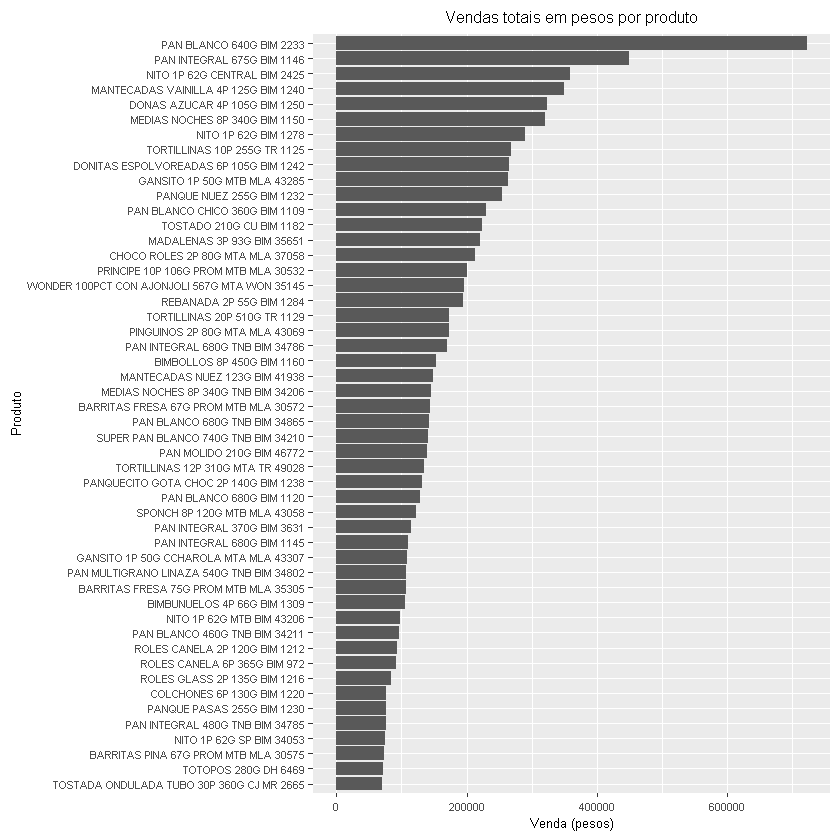

In [13]:
# GRÁFICO DOS 50 PRODUTOS DE MAIOR VENDA EM PESOS
g3 <- ggplot(produto_venda_peso[1:50,], aes(x = reorder(nome_produto, venda_peso_total), y = venda_peso_total)) +
    geom_bar(stat = "identity") + 
    labs(x = "Produto", y = "Venda (pesos)", title = "Vendas totais em pesos por produto") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

options(repr.plot.width = 7, repr.plot.height = 7)
g3

In [14]:
# 10 PRODUTOS COM MAIS VENDA EM PESOS
produto_venda_peso[c(1:10), c(2,6)]

nome_produto,venda_peso_total
PAN BLANCO 640G BIM 2233,722340.0
PAN INTEGRAL 675G BIM 1146,449523.2
NITO 1P 62G CENTRAL BIM 2425,358332.5
MANTECADAS VAINILLA 4P 125G BIM 1240,349051.2
DONAS AZUCAR 4P 105G BIM 1250,323292.8
MEDIAS NOCHES 8P 340G BIM 1150,319961.1
NITO 1P 62G BIM 1278,289690.9
TORTILLINAS 10P 255G TR 1125,268851.2
DONITAS ESPOLVOREADAS 6P 105G BIM 1242,264431.6
GANSITO 1P 50G MTB MLA 43285,264230.9


In [15]:
# 50 PRODUTOS DE MAIOR REEMBOLSO EM PESOS  
produto_retorno_peso <- agrupa_produto[order(agrupa_produto$devolucao_peso_total, decreasing = T),]

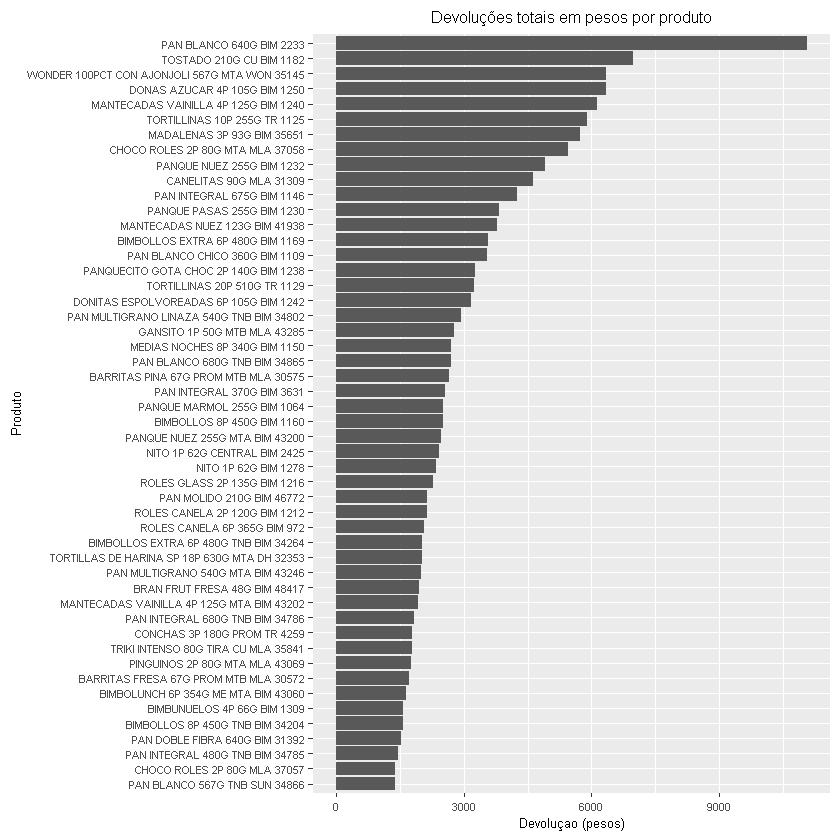

In [16]:
# GRÁFICO DOS 50 PRODUTOS DE MAIOR REEMBOLSO 
g4 <- ggplot(produto_retorno_peso[1:50,], aes(x = reorder(nome_produto, devolucao_peso_total), y = devolucao_peso_total)) +
    geom_bar(stat = "identity") + 
    labs(x = "Produto", y = "Devoluçao (pesos)", title = "Devoluções totais em pesos por produto") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

options(repr.plot.width = 7, repr.plot.height = 7)
g4

In [17]:
# 10 PRODUTOS QUE MAIS REEMBOLSO EM PESOS  
produto_retorno_peso[c(1:10), c(2,7)]

nome_produto,devolucao_peso_total
PAN BLANCO 640G BIM 2233,11062.70
TOSTADO 210G CU BIM 1182,6965.10
WONDER 100PCT CON AJONJOLI 567G MTA WON 35145,6349.67
DONAS AZUCAR 4P 105G BIM 1250,6346.63
MANTECADAS VAINILLA 4P 125G BIM 1240,6123.66
TORTILLINAS 10P 255G TR 1125,5897.60
MADALENAS 3P 93G BIM 35651,5722.50
CHOCO ROLES 2P 80G MTA MLA 37058,5456.79
PANQUE NUEZ 255G BIM 1232,4895.77
CANELITAS 90G MLA 31309,4631.25


O Pan Blanco 640g BIM 2233 é o que mais vende em pesos e é o 1º de maior reembolso em pesos aos fornecedores. 

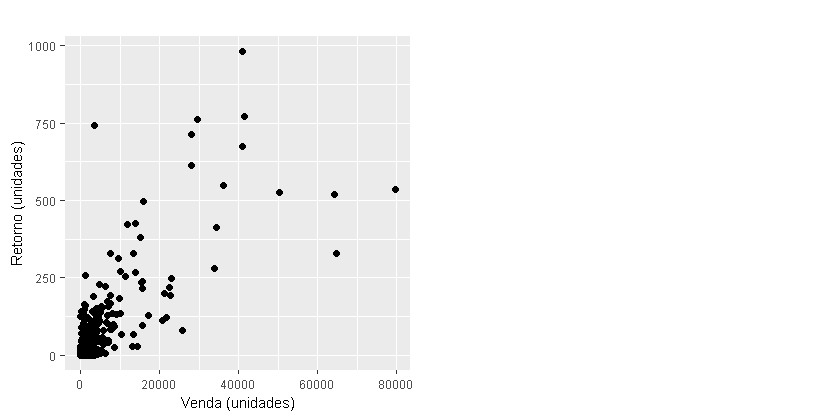

In [18]:
# GRÁFICO DE DISPERSÃO 
# VENDA TOTAL (UNIDADES) E RETORNO TOTAL (UNIDADES) 
g5 <- ggplot(agrupa_produto, aes(x = venda_unidade_total, y = retorno_unidade_total)) +
    geom_point() + 
    labs(x = "Venda (unidades)", y = "Retorno (unidades)", title = "") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 9)) 

options(repr.plot.width = 7, repr.plot.height = 3.5)
plot_grid(g5, ncol = 2, align = "hv")

<div style="text-align: justify;">
Existe uma correlação forte positiva de vendas totais de unidades  com retorno total de unidades. A partir do gráfico de dispersão, percebe-se que com aumento da venda total de unidades, o retorno total de unidades aumenta. Porém também existem valores que não possuem essa relação.
</div>

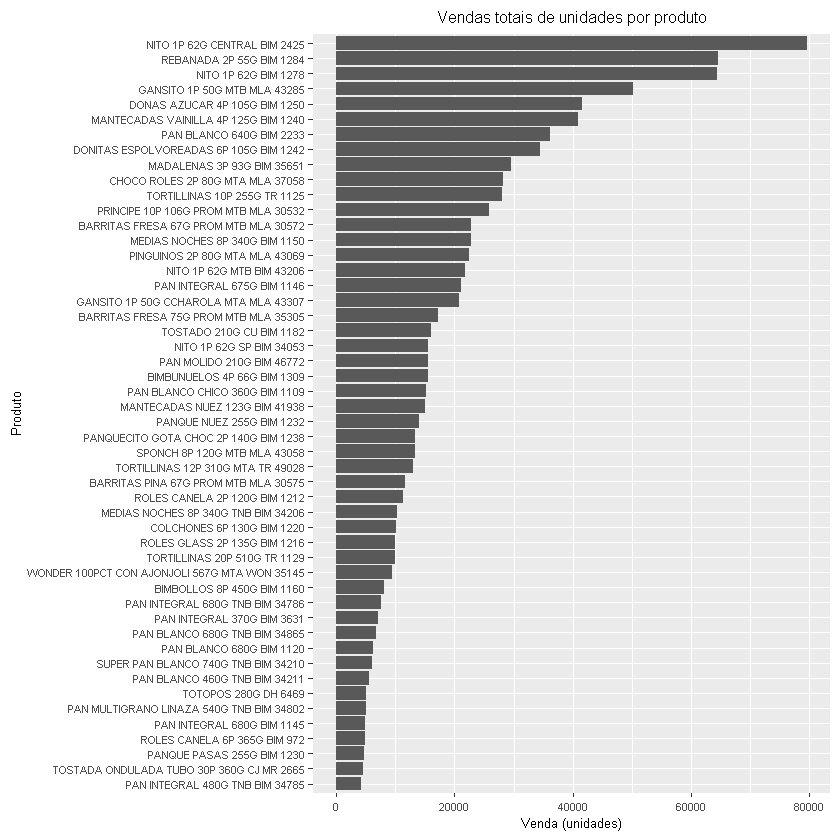

In [19]:
# GRÁFICO 50 PRODUTOS DE MAIOR VENDA DE UNIDADES
g6 <- ggplot(agrupa_produto[1:50,], aes(x = reorder(nome_produto, venda_unidade_total), y = venda_unidade_total)) +
    geom_bar(stat = "identity") + 
    labs(x = "Produto", y = "Venda (unidades)", title = "Vendas totais de unidades por produto") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

options(repr.plot.width = 7, repr.plot.height = 7)
g6

<div style="text-align: justify;">
O  Nito 1p 62g Central BIM 2425, que é o 3º que mais vende em pesos, é o primeiro colocado em venda de unidades. O Pan Blanco 640g BIM 2233, o que mais vende em pesos ocupa a 7º colocação em venda de unidades.
</div>

In [20]:
# 50 PRODUTOS DE MAIOR RETORNO DE UNIDADES 
produto_retorno_unidade <- agrupa_produto[order(agrupa_produto$retorno_unidade_total, decreasing = T),]

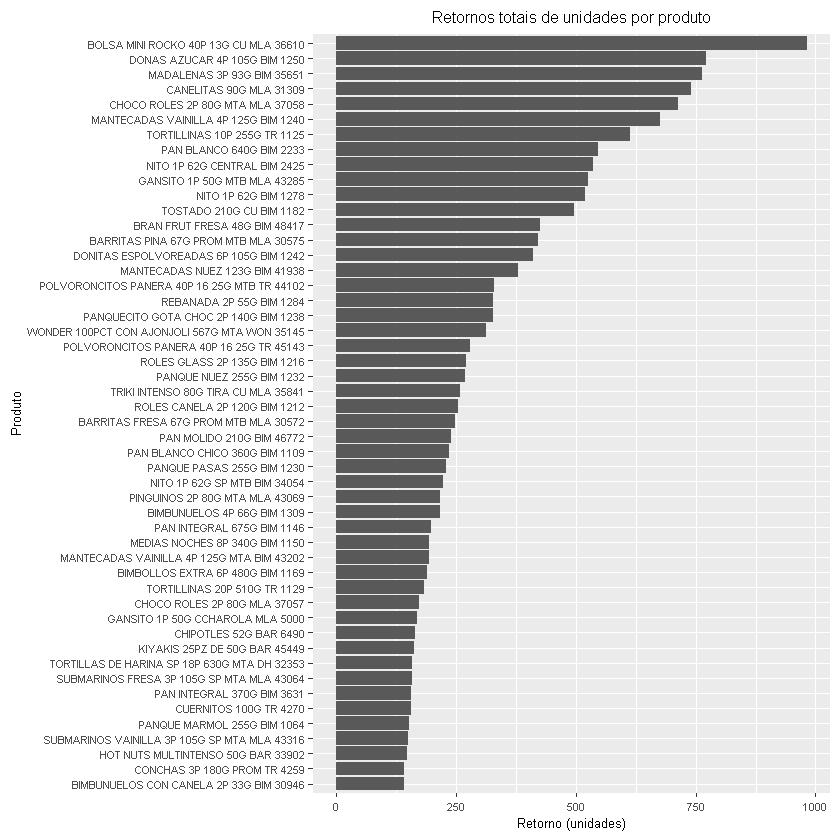

In [21]:
# GRÁFICO DOS 50 PRODUTOS DE MAIOR RETORNO DE UNIDADES 
g7 <- ggplot(produto_retorno_unidade[1:50,], aes(x = reorder(nome_produto, retorno_unidade_total), 
                                                 y = retorno_unidade_total)) +
    geom_bar(stat = "identity") + 
    labs(x = "Produto", y = "Retorno (unidades)", title = "Retornos totais de unidades por produto") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

options(repr.plot.width = 7, repr.plot.height = 7)
g7

#### **DEPÓSITOS**

In [22]:
# DEPÓSITO
estado_cidade_deposito <- df_bimbo %>%
    group_by(deposito_id) %>%
    summarise(demanda_ajustada_total = sum(demanda_ajustada),
            venda_unidade_total = sum(venda_unidade),
            retorno_unidade_total = sum(retorno_unidade),
            venda_peso_total = sum(venda_peso),
            devolucao_peso_total = sum(devolucao_peso)) %>%
    inner_join(df_estado, by = "deposito_id") %>%
    select(deposito_id, estado, cidade, everything())

In [23]:
# DEPÓSITOS
deposito1 <- estado_cidade_deposito[order(estado_cidade_deposito$venda_peso_total, decreasing = T),]
g9 <- ggplot(deposito1[1:8,], aes(x = reorder(deposito_id, -venda_peso_total), y = venda_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Depósito", y = "Venda (pesos)", title = "Vendas totais em pesos por depósito") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) 

deposito2 <- estado_cidade_deposito[order(estado_cidade_deposito$venda_unidade_total, decreasing = T),]
g10 <- ggplot(deposito2[1:8,], aes(x = reorder(deposito_id, -venda_unidade_total), y = venda_unidade_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Depósito", y = "Venda (unidades)", title = "Vendas totais em unidades por depósito") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) 

deposito3 <- estado_cidade_deposito[order(estado_cidade_deposito$devolucao_peso_total, decreasing = T),]
g11 <- ggplot(deposito3[1:8,], aes(x = reorder(deposito_id, -devolucao_peso_total), y = devolucao_peso_total )) +
    geom_bar(stat = "identity") +
    labs(x = "Depósito", y = "Devolução (pesos)", title = "Devoluções totais em pesos por depósito") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) 

deposito4 <- estado_cidade_deposito[order(estado_cidade_deposito$retorno_unidade_total, decreasing = T),]
g12 <- ggplot(deposito4[1:8,], aes(x = reorder(deposito_id, -retorno_unidade_total), y = retorno_unidade_total )) +
    geom_bar(stat = "identity") +
    labs(x = "Depósito", y = "Retorno (unidades)", title = "Retornos totais de unidades por depósito") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) 

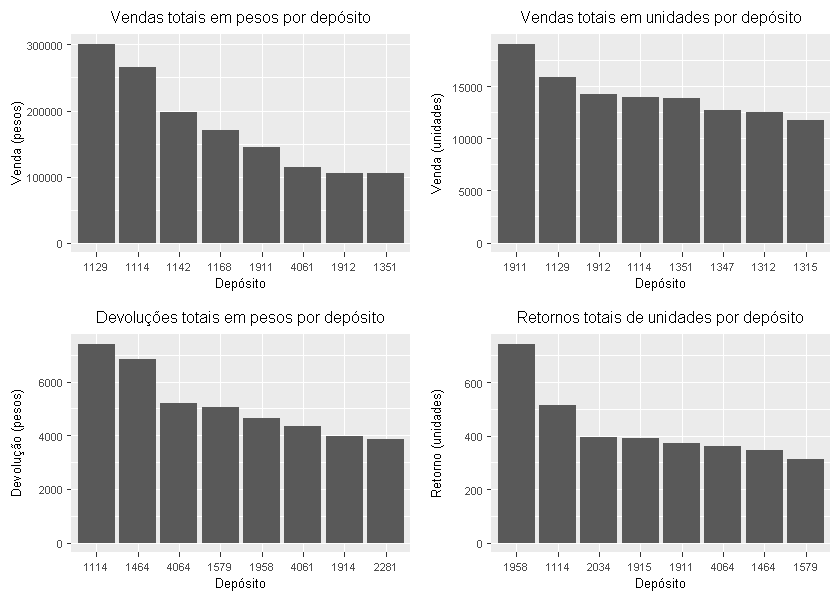

In [24]:
options(repr.plot.width = 7, repr.plot.height = 5)
plot_grid(g9, g10, g11, g12, ncol = 2, align = "hv")

#### **ESTADOS**

In [25]:
# ESTADO 
estado <- estado_cidade_deposito %>%
    group_by(estado) %>%
    summarise(demanda_ajustada_total = sum(demanda_ajustada_total),
            venda_unidade_total = sum(venda_unidade_total),
            retorno_unidade_total = sum(retorno_unidade_total),
            venda_peso_total = sum(venda_peso_total),
            devolucao_peso_total = sum(devolucao_peso_total))

In [26]:
# ESTADOS DE MAIOR VENDA EM PESOS
estado1 <- estado[order(estado$venda_peso_total, decreasing = T),]
g15 <- ggplot(estado1[1:8,], aes(x = reorder(estado, venda_peso_total), y = venda_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Estado", y = "Venda (pesos)", title = "Vendas totais em pesos por estado") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# ESTADOS DE MAIOR DEVOLUÇÃO EM PESOS
estado2 <- estado[order(estado$devolucao_peso_total, decreasing = T),]
g17 <- ggplot(estado2[1:8,], aes(x = reorder(estado, devolucao_peso_total), y = devolucao_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Estado", y = "Devolução (pesos)", title = "Devoluções totais em pesos por estado") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# ESTADOS DE MAIOR VENDA EM UNIDADES
estado3 <- estado[order(estado$venda_unidade_total, decreasing = T),]
g16 <- ggplot(estado3[1:8,], aes(x = reorder(estado, venda_unidade_total), y = venda_unidade_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Estado", y = "Venda (unidades)", title = "Vendas totais em unidades por estado") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# ESTADOS DE MAIOR RETORNO EM UNIDADES
estado4 <- estado[order(estado$retorno_unidade_total, decreasing = T),]
g18 <- ggplot(estado4[1:8,], aes(x = reorder(estado, retorno_unidade_total), y = retorno_unidade_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Estado", y = "Retorno (unidades)", title = "Retornos totais de unidades por depósito") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

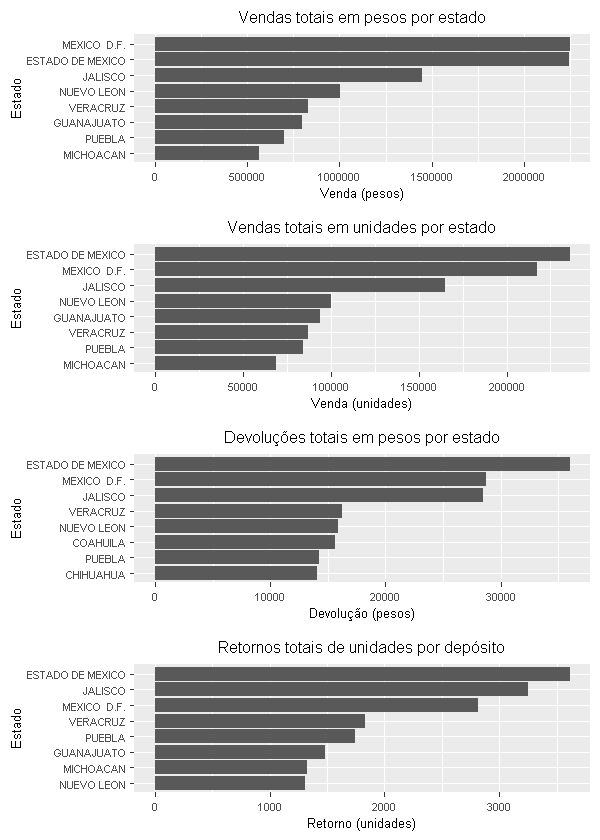

In [27]:
options(repr.plot.width = 5, repr.plot.height = 7)
plot_grid(g15, g16, g17, g18, ncol = 1, align = "hv")

#### **CIDADES**

In [28]:
# CIDADE 
cidade <- estado_cidade_deposito %>%
    group_by(cidade) %>%
    summarise(demanda_ajustada_total = sum(demanda_ajustada_total),
            venda_unidade_total = sum(venda_unidade_total),
            retorno_unidade_total = sum(retorno_unidade_total),
            venda_peso_total = sum(venda_peso_total),
            devolucao_peso_total = sum(devolucao_peso_total))

In [29]:
# CIDADES DE MAIOR VENDA EM PESOS
cidade1 <- cidade[order(cidade$venda_peso_total, decreasing = T),]
g19 <- ggplot(cidade1[1:8,], aes(x = reorder(cidade, venda_peso_total), y = venda_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Cidade", y = "Venda (pesos)", title = "Vendas totais em pesos por cidade") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# CIDADES DE MAIOR DEVOLUÇÃO EM PESOS
cidade2 <- cidade[order(cidade$venda_peso_total, decreasing = T),]
g20 <- ggplot(cidade2[1:8,], aes(x = reorder(cidade, devolucao_peso_total), y = devolucao_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Cidade", y = "Devolução (pesos)", title = "Devolução totais em pesos por cidade") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# CIDADES DE MAIOR VENDA EM UNIDADES
cidade3 <- cidade[order(cidade$venda_unidade_total, decreasing = T),]
g21 <- ggplot(cidade3[1:8,], aes(x = reorder(cidade, venda_unidade_total), y = venda_unidade_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Cidade", y = "Venda (unidades)", title = "Vendas totais de unidades por cidade") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# CIDADES DE MAIOR RETORNO EM UNIDADES
cidade4 <- cidade[order(cidade$retorno_unidade_total, decreasing = T),]
g22 <- ggplot(cidade4[1:8,], aes(x = reorder(cidade, retorno_unidade_total), y = retorno_unidade_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Cidade", y = "Retorno (unidades)", title = "Retorno totais de unidades por cidade") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

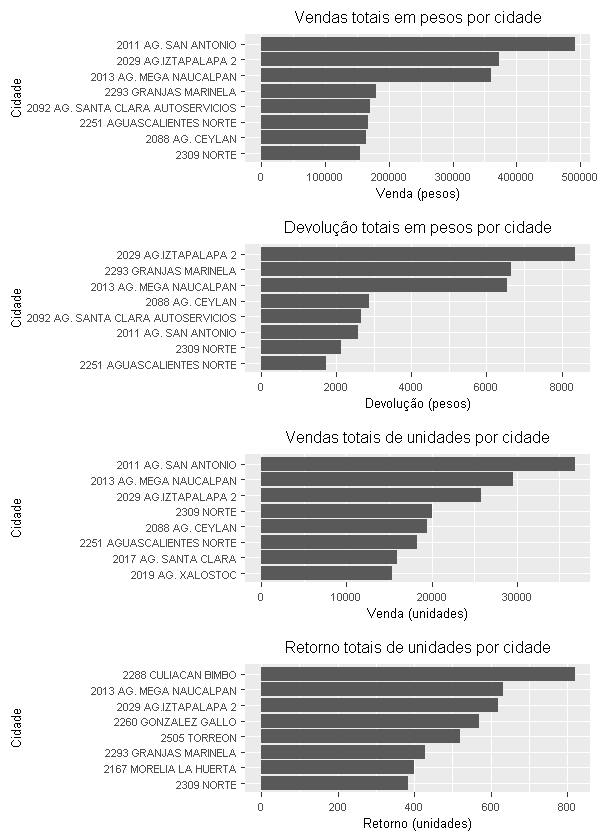

In [30]:
options(repr.plot.width = 5, repr.plot.height = 7)
plot_grid(g19, g20, g21, g22, ncol = 1, align = "hv")

#### **CLIENTES**

In [31]:
# CLIENTES
cliente <- df_bimbo %>%
    group_by(cliente_id) %>%
    summarise(demanda_ajustada_total = sum(demanda_ajustada),
            venda_unidade_total = sum(venda_unidade),
            retorno_unidade_total = sum(retorno_unidade),
            venda_peso_total = sum(venda_peso),
            devolucao_peso_total = sum(devolucao_peso)) %>%
    inner_join(df_cliente, by = "cliente_id") %>%
    select(nome_cliente, everything())

In [32]:
# CLIENTES QUE MAIS COMPRARAM EM PESOS
cliente1 <- cliente[order(cliente$venda_peso_total, decreasing = T),]
g19 <- ggplot(cliente1[1:5,], aes(x = reorder(nome_cliente, venda_peso_total), y = venda_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Cliente", y = "Compra (pesos)", title = "Compras totais em pesos por cliente") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

# CLIENTES COM MAIS DEVOLUÇÕES EM PESOS
cliente2 <- cliente[order(cliente$devolucao_peso_total, decreasing = T),]
g20 <- ggplot(cliente2[1:7,], aes(x = reorder(nome_cliente, devolucao_peso_total), y = devolucao_peso_total)) +
    geom_bar(stat = "identity") +
    labs(x = "Cliente", y = "Devolução (pesos)", title = "Devoluções totais em pesos por cliente") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()

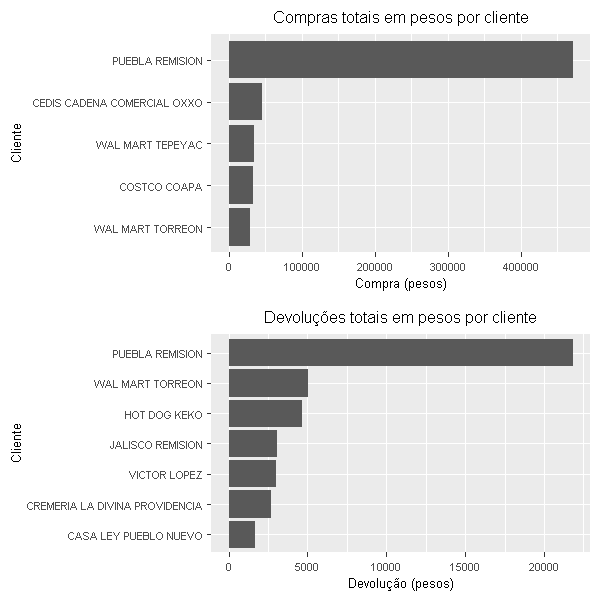

In [33]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot_grid(g19, g20, ncol = 1, align = "hv")

#### **CORRELAÇÃO DA VARIÁVEIS**

In [34]:
# CORRELAÇÃO DE VARIÁVEIS DO DATASET DA AMOSTRA DO DATASET PADRONIZADO
corr_df_bimbo <- cor(df_bimbo[, 7:11])
corr_df_bimbo

,venda_unidade,venda_peso,retorno_unidade,devolucao_peso,demanda_ajustada
venda_unidade,1.00000000,0.82655378,0.09432817,0.12252066,0.99849184
venda_peso,0.82655378,1.00000000,0.08291265,0.14598289,0.82470211
retorno_unidade,0.09432817,0.08291265,1.00000000,0.83233658,0.06237353
devolucao_peso,0.12252066,0.14598289,0.83233658,1.00000000,0.08757016
demanda_ajustada,0.99849184,0.82470211,0.06237353,0.08757016,1.00000000


<p>
<div style="text-align: justify;">
Na matriz de correlação percebe-se que existem variáveis altamente correlacionadas como <b>venda_peso</b> com <b>venda_unidade</b> e <b>retorno_unidade</b> com <b>retorno_peso</b>. Além disso, a variável <b>venda_peso</b> também possuí uma alta correlação com a variável dependente <b>demanda_ajustada</b>. Devido a alta correlação com outras variáveis independentes e também com a variável dependente, a variável <b>venda_peso</b> não será utilizada.
</div>
</p>

In [35]:
# CORRELAÇÃO DE VARIÁVEIS DO DATASET DA AMOSTRA DO DATASET PADRONIZADO
corr_df_bimbo <- cor(df_bimbo[, c(7,9:11)])
corr_df_bimbo

,venda_unidade,retorno_unidade,devolucao_peso,demanda_ajustada
venda_unidade,1.00000000,0.09432817,0.12252066,0.99849184
retorno_unidade,0.09432817,1.00000000,0.83233658,0.06237353
devolucao_peso,0.12252066,0.83233658,1.00000000,0.08757016
demanda_ajustada,0.99849184,0.06237353,0.08757016,1.00000000


In [36]:
set.seed(1908)

In [37]:
# DADOS DE TREINO (APROX. 70%) E TESTE (APROX. 30%)
divisao_treino_teste <- sample.split(df_bimbo$demanda_ajustada, SplitRatio = 0.70)

In [38]:
dados_treino <- subset(df_bimbo, divisao_treino_teste == TRUE)
dados_treino <- as.data.frame(dados_treino)
dados_teste <- subset(df_bimbo, divisao_treino_teste == FALSE)
dados_teste <- as.data.frame(dados_teste)

In [39]:
glimpse(dados_treino)

Rows: 171,527
Columns: 11
$ semana           <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,~
$ deposito_id      <int> 1126, 1595, 1232, 1631, 1222, 1614, 1238, 1387, 1470,~
$ canal_venda      <int> 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ rota_id          <int> 1024, 6602, 1004, 1256, 1002, 1016, 1104, 1214, 2107,~
$ cliente_id       <int> 1279340, 2388568, 78925, 4295781, 61159, 277610, 2384~
$ produto_id       <int> 1150, 44371, 1160, 1309, 3144, 2233, 31423, 2425, 430~
$ venda_unidade    <int> 2, 4, 8, 1, 1, 1, 1, 14, 4, 11, 3, 2, 5, 1, 1, 2, 36,~
$ venda_peso       <dbl> 27.92, 29.92, 150.88, 6.76, 21.32, 19.94, 10.69, 63.0~
$ retorno_unidade  <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ devolucao_peso   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ demanda_ajustada <int> 2, 4, 8, 1, 1, 1, 1, 14, 4, 11, 3, 2, 5, 1, 1, 2, 36,~


In [40]:
cat("Dados treino :", nrow(dados_treino),"observações")
cat("\nDados teste  :", nrow(dados_teste),"observações")

Dados treino : 171527 observações
Dados teste  : 73473 observações

In [41]:
# PREPARANDO DADOS DE TREINO E TESTE PARA O XGBOOST
x_treino = xgb.DMatrix(as.matrix(dados_treino[, c(1:10)]))
y_treino = dados_treino[, 11]

x_teste = xgb.DMatrix(as.matrix(dados_teste[, c(1:10)]))
y_teste = dados_teste[, 11]

### APRENDIZADO 

#### XGBOOST

In [42]:
# TRAIN CONTROL
trcontrol = trainControl(method = "cv",
                         number = 10,  
                         allowParallel = FALSE,
                         verboseIter = FALSE,
                         returnData = FALSE)

In [43]:
# GRID SEARCH
param_grid <- expand.grid(nrounds = c(200, 500, 1000),
                          max_depth = 6,
                          colsample_bytree = 0.7,
                          eta = 0.1,
                          gamma = 0,
                          min_child_weight = 1,
                          subsample = 0.7)

In [44]:
set.seed(1908)

In [45]:
# TREINO
xgb = train(x_treino, 
            y_treino,  
            trControl = trcontrol,
            tuneGrid = param_grid,
            method = "xgbTree",
            objective = "reg:squarederror")

print(xgb)

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 154373, 154375, 154376, 154375, 154375, 154374, ... 
Resampling results across tuning parameters:

  nrounds  RMSE      Rsquared   MAE       
   200     1.965814  0.9916623  0.20214700
   500     1.908696  0.9920461  0.12436368
  1000     1.898082  0.9921137  0.09822446

Tuning parameter 'max_depth' was held constant at a value of 6
Tuning
 parameter 'min_child_weight' was held constant at a value of 1

Tuning parameter 'subsample' was held constant at a value of 0.7
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were nrounds = 1000, max_depth = 6, eta
 = 0.1, gamma = 0, colsample_bytree = 0.7, min_child_weight = 1 and subsample
 = 0.7.


In [46]:
# PREVISÃO
prev_xgb = predict(xgb, x_teste)

In [47]:
# VERIFICANDO VALORES NEGATIVOS NA COLUNA DE PREVISÃO
any(prev_xgb < 0)

[1] TRUE

In [48]:
# TRATANDO OS VALORES NEGATIVOS DA PREVISÃO
converterNegativo <- function(vetor){
    for (p in vetor){
        if (p < 0){
            return(0)
        } else{
            return(p)
        }
    }
}

prev_xgb <- sapply(prev_xgb, converterNegativo)

# EXISTE VALORES NEGATIVOS?
any(prev_xgb < 0)

[1] FALSE

In [49]:
# UNINDO COLUNA DE PREVISÃO AO DATASET
resultados <- cbind(dados_teste, prev_xgb)
head(resultados[, c(11, 12)])

demanda_ajustada,prev_xgb
1,1.0027364
1,0.9793775
3,2.9884274
1,1.0178751
3,3.0091863
15,15.0416565


### AVALIAÇÃO 

In [50]:
# CÁLCULAR RESÍDUOS
calculo_residuos = y_teste - prev_xgb
df_residuos = as.data.frame(cbind(previsto = prev_xgb, residuos = calculo_residuos))

`geom_smooth()` using formula 'y ~ x'


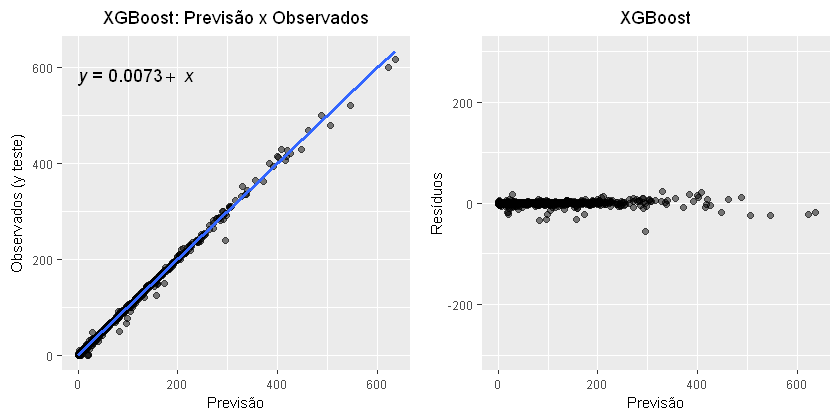

In [51]:
# GRÁFICO COM A RETA ENCONTRADA
df_reta = as.data.frame(cbind(predito = prev_xgb, observado = y_teste))
g_reta <- ggplot(df_reta, aes(x = predito, y = observado)) + 
          geom_point(color = "black", alpha = 0.5) + 
          geom_smooth(method = "lm") + 
          labs(x = "Previsão", y = "Observados (y teste)", title = "XGBoost: Previsão x Observados") +
          theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 9)) +
          stat_regline_equation(aes(label =  paste(..eq.label..)))


# GRÁFICO DE RESÍDUOS
g_residuos <- ggplot(df_residuos, (aes(x = prev_xgb, y = residuos))) +
    geom_point(color = "black", alpha = 0.5) + 
    scale_y_continuous(limits = c(-300, 300)) +
    labs(x = "Previsão", y = "Resíduos", title = "XGBoost") +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 9)) 


options(repr.plot.width = 7, repr.plot.height = 3.5)
plot_grid(g_reta, g_residuos, ncol = 2, align = "hv")

In [52]:
# MÉTRICAS
# MSE - ERRO QUADRÁTICO MÉDIO 
# É A MÉDIA DO ERRO DAS PREVISÕES AO QUADRADO. QUANTO MAIOR, PIOR O MODELO.
MSE <- round(sum((y_teste - prev_xgb)^2)/nrow(dados_teste), 4)

# RMSE - RAÍZ DO ERRO QUADRÁTICO MÉDIO 
# RAÍZ DO MSE. MELHORA A INTERPRETABILIDADE EM COMPARAÇÃO COM O MSE.
RMSE <- round(sqrt(MSE), 4)

# MAE - ERRO MÉDIO ABSOLUTO 
# É A MÈDIA DAS DISTÂNCIAS ENTRE VALORES PREVISTOS E REAIS. POSSUI A MESMA UNIDADE DOS DADOS TRABALHADOS. DÁ A IDEIA DO
# QUÃO ERRADAS ESTÃO AS PREVISÕES
MAE <- round(sum(abs(y_teste - prev_xgb))/nrow(dados_teste), 4)

# R² - COEFICIENTE DE DETERMINAÇÃO (NÍVEL DE PRECISÃO DAS PREVISÕES EM RELAÇÃO AOS VALORES OBSERVADOS)
# INFORMA O PERCENTUAL DA VARIABILIDADE OU VARIÂNCIA DOS DADOS QUE SÂO EXPLICADAS PELO MODELO CONSTRUÍDO
SSE = sum((y_teste - prev_xgb)^2)
SST = sum((y_teste - mean(y_teste))^2)
R2 = round(1 - (SSE/SST), 4)

# R² AJUSTADO - COEFICIENTE DE DETERMINAÇÃO 
R2_ajust = round(1 - ((1 - R2) * (nrow(dados_teste) - 1))/(nrow(dados_teste) - (ncol(dados_teste) - 1) - 1), 4)

cat("Resultados do teste do Modelo de Regressão com XGBoost:") 
cat("\n\nMSE  = ",MSE,"\nRMSE = ", RMSE,"\nMAE  = ",MAE,"\nR²   = ", R2, "\nR²ajust = ", R2_ajust)

Resultados do teste do Modelo de Regressão com XGBoost:

MSE  =  0.2598 
RMSE =  0.5097 
MAE  =  0.051 
R²   =  0.999 
R²ajust =  0.999

#### CONCLUSÃO

O modelo XGBoost obteve um bom desempenho com um R² igual 0.999 e RMSE baixo.